# 데이터 불러오기

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 경고 무시
warnings.filterwarnings('ignore')

#한글 처리를 위해 폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
df = pd.read_csv('../csv/preprocess.csv')
df.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_24h,date_of_birth_distinct_emails_4w,...,BE,BF,BG,INTERNET,TELEAPP,linux,macintosh,other,windows,x11
0,0,0.9,0.642713,0.0,20,0.009624,105.898067,1724,7394.902554,8,...,1,0,0,1,0,0,0,1,0,0
1,0,0.9,0.720064,200.0,40,0.007018,33.006203,1986,5416.601990,5,...,1,0,0,1,0,0,0,0,1,0
2,0,0.9,0.075432,129.0,40,0.009764,-0.632448,2411,7423.819019,7,...,0,0,0,1,0,0,0,0,1,0
3,0,0.5,0.784344,240.0,20,0.017281,-1.612753,1731,4489.610329,8,...,1,0,0,1,0,1,0,0,0,0
4,0,0.8,0.770435,150.0,40,9.370346,26.733867,1863,6301.097061,7,...,0,0,0,1,0,1,0,0,0,0


# 분석

In [4]:
train_cols = df.columns[1:]
X = df[train_cols] # 독립변수
y = df["fraud_bool"] # 종속변수
df["fraud_bool"].value_counts()

0    6871
1    6871
Name: fraud_bool, dtype: int64

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

In [6]:
pipe = Pipeline([
('scaler', StandardScaler()),
('clf', DecisionTreeClassifier(random_state=0)),
])
params = {
'clf__max_depth': list(range(3,10))
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

{'clf__max_depth': 4}
0.6928430893123201


In [7]:
# {'clf__max_depth': 4}
# 0.6928430893123201

# 시각화

In [8]:
tree=grid.best_estimator_['clf']

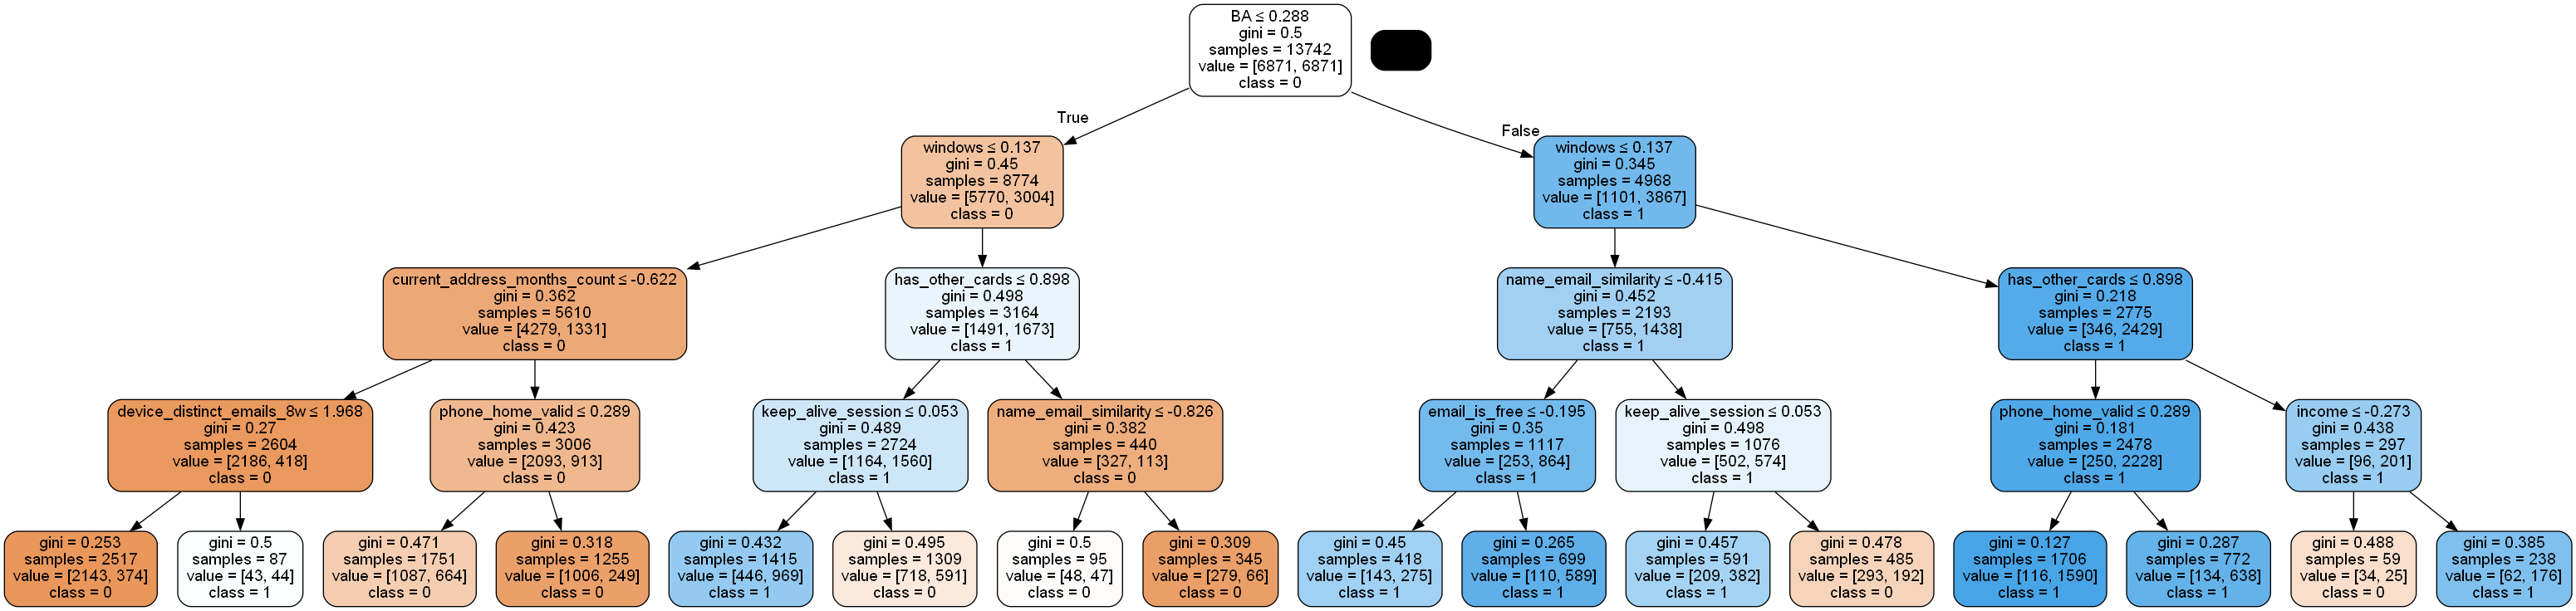

In [9]:
from sklearn.tree import export_graphviz
import pydotplus
import graphviz
from IPython.display import Image
dot_data = export_graphviz(tree, out_file=None,
feature_names=train_cols, class_names=["0","1"], filled=True,
rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

# 저장